In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'jeejeeyoung' # username
os.environ['KAGGLE_KEY'] = '9ac1aa0685cbd6493cfb8ae6fc1a67bb' # key

구글, 캐글 연동
- https://soohee410.github.io/colab_kaggle

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeejeeyoung","key":"9ac1aa0685cbd6493cfb8ae6fc1a67bb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

데이터셋 다운로드/정리

In [ ]:
# dfdc(deepfake detection challenge) competition에서 제공하는 데이터셋 다운로드
#!kaggle competitions download -c deepfake-detection-challenge

In [ ]:
#!mkdir train_sample_videos
#!mv *.zip /content/train_sample_videos

In [ ]:
#!unzip \*.zip

In [ ]:
#rm -rf *.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#mv *.mp4 /content/train_sample_videos/

기타 필요한 라이브러리 다운로드 

In [ ]:
!kaggle datasets list -s facenet

ref                                            title                             size  lastUpdated          downloadCount  
---------------------------------------------  -------------------------------  -----  -------------------  -------------  
timesler/facenet-pytorch-vggface2              facenet pytorch vggface2         112MB  2020-03-12 03:27:00           1359  
suicaokhoailang/facenet-keras                  facenet keras                     81MB  2019-05-15 11:07:22           1189  
samusram/dfdcfacenetembeddings                 dfdc-facenet-embeddings           91MB  2020-04-02 05:22:48              4  
nikhil1011/facenet                             facenet                          324MB  2019-07-08 08:49:27             33  
carlossouza/facenetpytorch                     facenet-pytorch                    2MB  2019-12-25 02:02:06              7  
havingfun/100-bollywood-celebrity-faces        Bollywood Celebrity Faces          2GB  2020-03-21 10:15:17           1482  
shanmukh

In [ ]:
# facenet : Pretrained weights for face detection and recognition.
# https://www.kaggle.com/timesler/facenet-pytorch-vggface2
!kaggle datasets download -d timesler/facenet-pytorch-vggface2

 94% 105M/112M [00:01<00:00, 87.3MB/s] 
100% 112M/112M [00:01<00:00, 92.3MB/s]


In [ ]:
!cd /content/
!mkdir facenet-pytorch-vggface2

In [ ]:
!unzip facenet-pytorch-vggface2.zip

Archive:  facenet-pytorch-vggface2.zip
  inflating: 20180402-114759-vggface2-features.pth  
  inflating: 20180402-114759-vggface2-logits.pth  
  inflating: facenet_pytorch-1.0.1-py3-none-any.whl  
  inflating: facenet_pytorch-2.0.0-py3-none-any.whl  
  inflating: facenet_pytorch-2.0.1-py3-none-any.whl  
  inflating: facenet_pytorch-2.1.0-py3-none-any.whl  
  inflating: facenet_pytorch-2.1.1-py3-none-any.whl  
  inflating: facenet_pytorch-2.2.7-py3-none-any.whl  
  inflating: facenet_pytorch-2.2.9-py3-none-any.whl  


In [ ]:
!mv *.whl facenet-pytorch-vggface2/
!mv *.pth facenet-pytorch-vggface2/

In [ ]:
!pip install /content/facenet-pytorch-vggface2/facenet_pytorch-2.0.0-py3-none-any.whl

Processing ./facenet-pytorch-vggface2/facenet_pytorch-2.0.0-py3-none-any.whl


In [ ]:
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p $torch_home/checkpoints/
!cp /content/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth $torch_home/checkpoints/vggface2_DG3kwML46X.pt
!cp /content/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth $torch_home/checkpoints/vggface2_G5aNV2VSMn.pt

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/train_sample_videos/'
BATCH_SIZE = 1
SCALE = 0.25
N_FRAMES = None # The number of frames extracted from each video, 'None' means get all available frames

In [ ]:
cd /content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/train_sample_videos

[Errno 2] No such file or directory: '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/train_sample_videos'
/content


In [ ]:
ls -l|wc -l

6


In [ ]:
import os
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        # CAP_PROP_FRA,E_COUNT : 동영상 총 프레임 수 출력
        # https://076923.github.io/posts/Python-opencv-4/
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)) 

        # Pick 'n_frames' evenly spaced frames to sample

        # linspace() : 1차원 배열 만들기, 수평축 간격 만들기 등에 활용
        # np.linspace(start,stop,num)
        # https://m.blog.naver.com/choi_s_h/221730568009
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
          #cv2.VideoCapture.grab() : 비디오 파일, 영상 장치로부터 다른 frame 반환, 성공 시 True 리턴
            success = v_cap.grab()
            if j in sample:
                # Load frame
                #cv2.VideoCapture.retrieve() : grab한 frame을 decode해서 반환
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # numpy 배열을 PIL 이미지로 변환
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                # PIL.resize() : https://ponyozzang.tistory.com/600
                # frame.size는 (width,height) 반환
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces

In [ ]:
# pytorch 기본 연산 : https://gaussian37.github.io/dl-pytorch-basic/

In [ ]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
def process_faces(faces, feature_extractor):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    if len(faces) == 0:
        return None
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = feature_extractor(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    # centroid : 도형의 중심
    #.mean(dim=0) : 첫번째 차원 단위의 평균 , https://curioso365.tistory.com/48
    centroid = embeddings.mean(dim=0)
    # 거리를 구한 후 cpu로 다시 전송하고 numpay 배열로 변환
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

In [ ]:
# Load face detector
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()
# Load facial recognition model
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=face_detector, n_frames=N_FRAMES, batch_size=BATCH_SIZE, resize=SCALE)

In [ ]:
# Get the paths of all train videos
# glob.glob() : 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))

# Get path of metadata.json
metadata_path = TRAIN_DIR + 'metadata.json'

# Get metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

FileNotFoundError: ignored

In [ ]:
"""df = pd.DataFrame(columns=['filename', 'distance', 'label'])

with torch.no_grad():
    for path in tqdm(all_train_videos):
        file_name = path.split('/')[-1]

        # Detect all faces occur in the video
        faces = detection_pipeline(path) #detection_pipeline 객체는 callable
        
        # Calculate the distances of all faces' feature vectors to the centroid
        distances = process_faces(faces, feature_extractor)
        if distances is None:
            continue

        for distance in distances:
            row = [
                file_name,
                distance,
                1 if metadata[file_name]['label'] == 'FAKE' else 0
            ]

            # Append a new row at the end of the data frame
            df.loc[len(df)] = row"""

In [ ]:
"""df.head()
df.shape"""

In [ ]:
#df.to_csv('train.csv', index=False)

In [ ]:
#mv train.csv /content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/train.csv'
SAVE_PATH = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/model/model.pth'
TEST_SIZE = 0.3
RANDOM_STATE = 128
EPOCHS = 200
BATCH_SIZE = 64
LR = 1e-4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        y_pred = self.linear(x)

        return y_pred
    
    def predict(self, x):
        result = self.forward(x)

        return torch.sigmoid(result)

In [ ]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    
    p = np.random.permutation(len(X))
    
    return X[p], y[p]

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,filename,distance,label
0,eczrseixwq.mp4,0.494105,1
1,eczrseixwq.mp4,0.495248,1
2,eczrseixwq.mp4,0.518513,1
3,eczrseixwq.mp4,0.497832,1
4,eczrseixwq.mp4,0.507992,1


In [ ]:
r_idx =[i for i in range(train_df.shape[0]-1,-1,-1)]
train_df = pd.DataFrame(train_df,index=r_idx)
train_df.shape

(127555, 3)

In [ ]:
# groupby().count(): https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221578773214
label_count = train_df.groupby('label').count()['filename']
print(label_count)

# Use pos_weight value to overcome imbalanced dataset.
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
pos_weight = torch.ones([1]) * label_count[0]/label_count[1]
print('pos_weight:', pos_weight)

label
0     27476
1    100079
Name: filename, dtype: int64
pos_weight: tensor([0.2745])


In [ ]:
# X : data, y : label
X = train_df['distance'].to_numpy()
y = train_df['label'].to_numpy()

In [ ]:
# train_test_split : https://teddylee777.github.io/scikit-learn/train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [ ]:
# unsqueeze : 차원 추가
X_train = torch.tensor(X_train).to(device).unsqueeze(dim=1).float()
X_val = torch.tensor(X_val).to(device).unsqueeze(dim=1).float()
y_train = torch.tensor(y_train).to(device).unsqueeze(dim=1).float()
y_val = torch.tensor(y_val).to(device).unsqueeze(dim=1).float()

print(X_train)

tensor([[0.9995],
        [0.4798],
        [0.2652],
        ...,
        [0.6065],
        [0.2629],
        [0.3330]])


In [ ]:
classifier = LogisticRegression()
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight) # Improve stability
optimizer = optim.Adam(classifier.parameters(), lr=LR)

for name,p in classifier.named_parameters():
  print(f'name:{name}')
  print(p)
  print(type(p))
  print(f'p.shape:{p.shape}')
  print(f'p.requries_grad:{p.requires_grad}')
  print('=====')

n_batches = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
losses = np.zeros(EPOCHS)
val_losses = np.zeros(EPOCHS)
best_val_loss = 1e7

for e in tqdm(range(EPOCHS)):
    batch_losses = np.zeros(n_batches)
    pbar = tqdm(range(n_batches))
    pbar.desc = f'Epoch {e+1}'
    classifier.train()
    
    # Shuffle training data
    X_train, y_train = shuffle_data(X_train, y_train)

    for i in pbar:
        # Get batch.
        X_batch = X_train[i*BATCH_SIZE:min(len(X_train), (i+1)*BATCH_SIZE)]
        y_batch = y_train[i*BATCH_SIZE:min(len(y_train), (i+1)*BATCH_SIZE)]

        # Make prediction.
        #X_batch = torch.tensor(X_batch).to('cuda:0!').unsqueeze(dim=1).float()
        #X_batch.to('cuda:0!')
        y_pred = classifier(X_batch)

        # Compute loss.
        loss = criterion(y_pred, y_batch)
        batch_losses[i] = loss

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute batch loss (average)
    losses[e] = batch_losses.mean()
    
    # Compute val loss
    classifier.eval()
    y_val_pred = classifier(X_val)
    val_losses[e] = criterion(y_val_pred, y_val)
    
    # Save model based on the best (lowest) val loss.
    if val_losses[e] < best_val_loss:
        print('Found a better checkpoint!')
        torch.save(classifier.state_dict(), SAVE_PATH)
        best_val_loss = val_losses[e]
        
    
    # Display some information in progress-bar.
    pbar.set_postfix({
        'loss': losses[e],
        'val_loss': val_losses[e]
    })

name:linear.weight
Parameter containing:
tensor([[-0.5003]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1, 1])
p.requries_grad:True
=====
name:linear.bias
Parameter containing:
tensor([0.0226], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1])
p.requries_grad:True
=====



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!



Found a better checkpoint!


In [ ]:
for name,p in classifier.named_parameters():
  print(f'name:{name}')
  print(p)
  print(type(p))
  print(f'p.shape:{p.shape}')
  print(f'p.requries_grad:{p.requires_grad}')
  print('=====')

name:linear.weight
Parameter containing:
tensor([[-0.9900]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1, 1])
p.requries_grad:True
=====
name:linear.bias
Parameter containing:
tensor([0.5021], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1])
p.requries_grad:True
=====


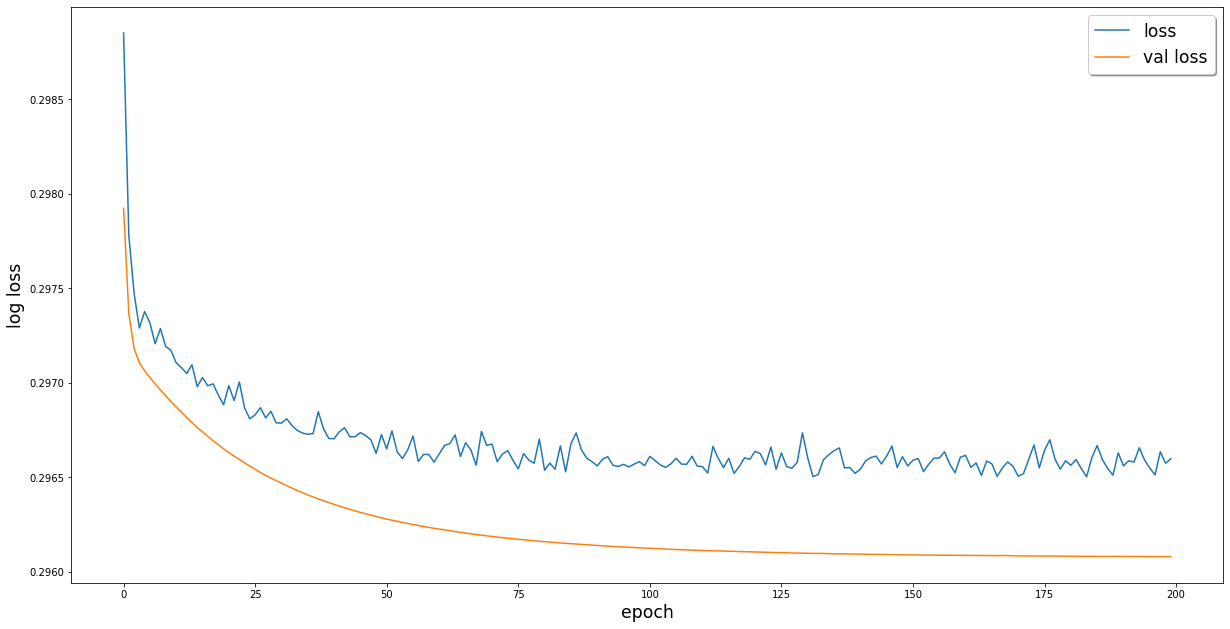

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(EPOCHS), losses)
ax.plot(np.arange(EPOCHS), val_losses)
ax.set_xlabel('epoch', fontsize='xx-large')
ax.set_ylabel('log loss', fontsize='xx-large')
ax.legend(
    ['loss', 'val loss'],
    loc='upper right',
    fontsize='xx-large',
    shadow=True
)
plt.show()

In [ ]:
without_weight_criterion = nn.BCELoss(reduction='mean')

classifier.eval()
with torch.no_grad():
    y_val_pred = classifier.predict(X_val)
    val_loss = without_weight_criterion(y_val_pred, y_val)

print('val loss:', val_loss.detach().numpy())

val loss: 0.68710667


In [ ]:
TEST_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/test_videos/'
MODEL_PATH = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/model/model.pth'

BATCH_SIZE = 60
SCALE = 0.25
N_FRAMES = None # 'None' means using all available frames
DEFAULT_PROB = 0.5

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
# Load model.
classifier = LogisticRegression()
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval()

LogisticRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
import glob
import os
all_test_videos = glob.glob(os.path.join(TEST_DIR, '*.mp4'))

In [ ]:
# Define face detection pipeline.
# Load face detector.
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model.
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()
# Define face detection pipeline.
detection_pipeline = DetectionPipeline(detector=face_detector, n_frames=N_FRAMES, batch_size=BATCH_SIZE, resize=SCALE)

In [ ]:
for name,p in classifier.named_parameters():
  print(f'name:{name}')
  print(p)
  print(type(p))
  print(f'p.shape:{p.shape}')
  print(f'p.requries_grad:{p.requires_grad}')
  print('=====')

name:linear.weight
Parameter containing:
tensor([[-0.9902]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1, 1])
p.requries_grad:True
=====
name:linear.bias
Parameter containing:
tensor([0.5011], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
p.shape:torch.Size([1])
p.requries_grad:True
=====


In [ ]:
X_test = []

with torch.no_grad():
    for path in tqdm(all_test_videos):
        try:
            # Detect all faces occur in the video.
            faces = detection_pipeline(path)

            # Calculate the distances of all faces' feature vectors to the centroid.
            distances = process_faces(faces, feature_extractor)
            X_test.append(distances)
        except: 
            X_test.append(None)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a lis

In [ ]:
submission = []

with torch.no_grad():
    for path, distances in zip(all_test_videos, X_test):
        file_name = os.path.basename(path)

        if distances is not None:
            distances = torch.tensor(distances).unsqueeze(dim=1).float().to(device)
            y_pred = classifier(distances)
            y_pred = float(y_pred.mean().cpu().numpy())
        else:
            y_pred = DEFAULT_PROB

        submission.append([file_name, y_pred])

In [ ]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
submission.sort_values('filename').to_csv('submission2.csv', index=False)

plt.hist(submission.label, 20)
plt.show()

In [ ]:
mv submission2.csv /content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder